# Credit Card Fraud Detection
Author: Ariel Salazar

### Abstract

Owning a credit card has many benefits, such as eliminating the need to carry cash and building credit to buy assets such as houses and cars. However, since credit cards are closely associated with a cardholder's identity, banks must have an efficient system to work with if cardholders happen to lose their credit cards or have them stolen. This project aims to download a dataset called Credit Card Fraud Detection from Kaggle and create reliable predictive models to detect when transactions are fraudulent. One of the most significant challenges when predicting fraudulent activity is that the event is rare. Hence, it may be challenging to train a model to detect such activity, given a small amount of fraudulent transactions. The approaches involved in this analysis include Logistic Regression with decision threshold tuning, Support Vector Machines, generating synthetic fraudulent transactions, removing outliers to decrease the amount of noise in the data, and much more. 

### Introduction
Owning a credit card has many benefits, including eliminating the need to carry cash and building credit as a way of building a reputation for being capable of making payments on assets, such as houses and cars. Since a credit card is closely associated with a cardholder, cases in which cardholders have their credit cards stolen or their credit card information is used to make purchases unauthorized by the cardholder can both lead to complicated situations for banks to resolve. To ensure the safety and trust of the customer, our goal will be to produce a reliable way of detecting fraudulent credit card transactions to resolve the cardholder's problem as efficiently as possible. 

### Background
While credit card fraud is known to be one of the most common types of identity theft, the proportion of fraudulent transactions to non-fraudulent transactions may not always be balanced. Such a fact will pose a non-trivial question regarding how to create an accurate machine learning model that is capable of detecting fraudulent activity even if there are few observations to learn from in a sample of data. A potential solution to this problem (which does not involve gathering more data) may involve generating enough synthetic fraudulent data to classify transactions more accurately while minimizing the amount of noise generated in the process. 

The dataset we will use for this experiment is called "Credit Card Fraud Detection" and can be accessed by clicking [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). According to this source [1], the dataset contains transactions made by European cardholders in September 2013 and has been collaboratively collected and analyzed by the ULB Machine Learning Group in the University of Brussels and Worldline. 

### Methods

The following is a summary of the methods that are applied in this section:
1. Loading the dataset and performing exploratory data analysis.
2. Check if the data is linearly separable.
3. Preprocess the data by scaling the features between $[0, 1]$.
4. Perform feature selection using Lasso Regression to remove any features that are creating noise. 
5. Creating an initial Logistic Regression model as the starting point of the modeling.
6. Balance the data using SMOTE to oversample the minority class (fraud). 
7. Tune the Logistic Regression decision threshold to maximize the accuracy of the model.
8. Create an initial SVM classifier. 
9. Remove the outliers only from the majority class to remove more noise.
10. Recreate the Logistic Regression and SVM models and include the outlier removal. 
11. Evaluate both models using stratified k-fold cross validation.

#### Loading and Viewing the Data
We will begin this experiement by loading the data and identifying what kind of features we will be working with. We will also aim to identify any problems that must be considered prior to the modeling phase, such as imbalanced data. 

In [ ]:
# import packages to assist the data analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy import stats

In [ ]:
# load data for Google Colab
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/creditcard.csv')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# load data for local workspace (do NOT run on Google Colab)
#data = pd.read_csv("creditcard.csv")
#data.head()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284806 entries, 0 to 284805
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284806 non-null  float64
 1   V1      284806 non-null  float64
 2   V2      284806 non-null  float64
 3   V3      284806 non-null  float64
 4   V4      284806 non-null  float64
 5   V5      284806 non-null  float64
 6   V6      284806 non-null  float64
 7   V7      284806 non-null  float64
 8   V8      284806 non-null  float64
 9   V9      284806 non-null  float64
 10  V10     284806 non-null  float64
 11  V11     284806 non-null  float64
 12  V12     284806 non-null  float64
 13  V13     284806 non-null  float64
 14  V14     284806 non-null  float64
 15  V15     284806 non-null  float64
 16  V16     284806 non-null  float64
 17  V17     284806 non-null  float64
 18  V18     284806 non-null  float64
 19  V19     284806 non-null  float64
 20  V20     284806 non-null  float64
 21  V21     28

We can see above that our dataset is comprised of $284,806$ credit card transactions, $30$ features, and $1$ binary target. Below is a description of all the features and target.

| Feature | Description |
| ----------- | ----------- |
| Time | Number of seconds elapsed since the first transaction occured |
| V1-V28 | Continuous credit card features |
| Amount | Transaction amount |
| Class | Fraudulent: 1, Non-fraudulent: 0 |

According to the page on Kaggle [1], the features $V1$ to $V28$ are the result of a PCA Dimensionality reduction, which means that this will not be one of our methods. Also, further information about the features is not disclosed due to confidentiality.  


Next, we should check how balanced the data is. 

In [ ]:
# Separate the data into features and target
X = data.drop(["Class"], axis=1)
y = data["Class"]
y.value_counts()

0    284314
1       492
Name: Class, dtype: int64

We can see above that the data is highly unbalanced with respect to the target values. This is something we will need to consider after our exploratory data analysis. 

#### Exploratory Data Analysis

##### Boxplots
Now we will try to understand the main characteristics of the features and their relationship to the target. We will create boxplots to compare each feature between the two classes to identify any correlations, differences in data between both classes (fraudulent and non-fraudulent), and any additional problems that must be resolved in the preprocessing phase. 

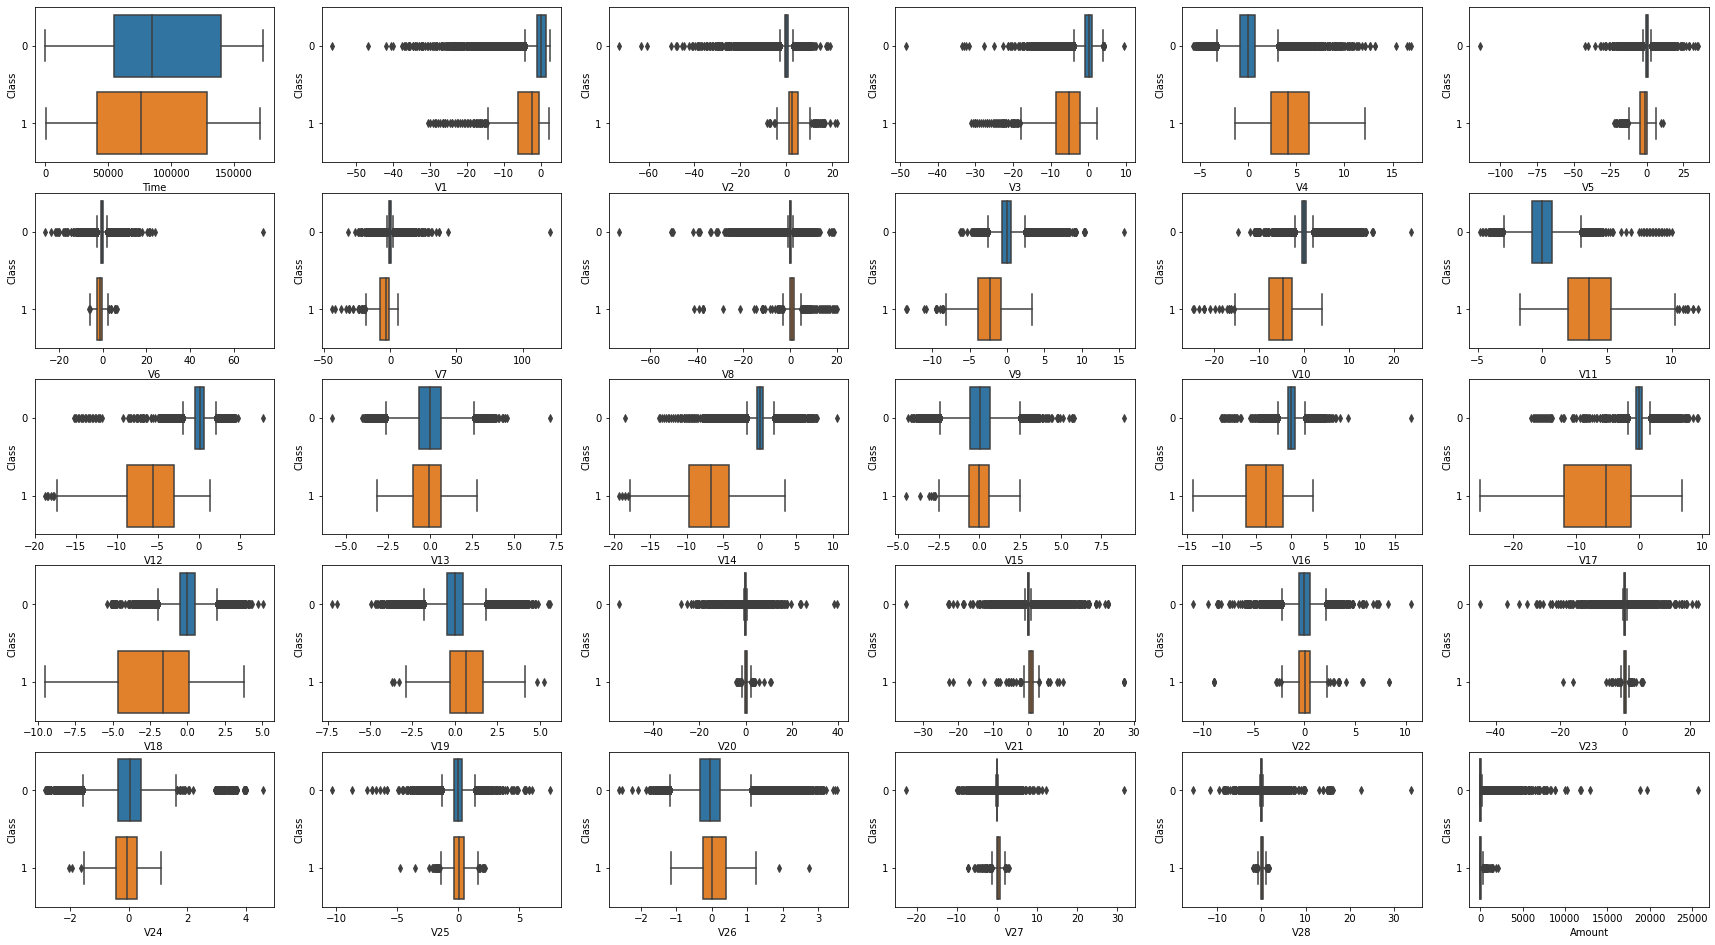

In [ ]:
# boxplots of all features
fig, axes = plt.subplots(5, 6)
for index, col in enumerate(X):
    ax = sns.boxplot(data=data, x=col, y="Class", orient="h", ax=axes[index // 6, index % 6])
plt.subplots_adjust(top=3.25, right=4.0)

We can see above that there are a few things we need to keep in mind about this dataset. 

First, there are a TON of outliers for each feature and in both the fraudulent and non-fraudulent classes. In machine learning, outliers are known to mislead the training process by increasing training times and reducing accuracy. Also, we want to create models that make a generalization about the data, so outliers may cause problem when trying to do so. However, while outlier removal sounds like a good idea, we would not like to lose a lot of observations classified as fraudulent because they are scarce. 

Also, there seems to be overlapping between both classes in all of the features. While it may have been expected already, the dataset we are working with does not seem to be linearly separable. However, it is still a good idea to ensure that that claim is true. We can overfit our data to a Perceptron to measure the data's linear separability. 

For our next steps in the analysis, we should try a couple of things:
1. Plot the same boxplots without the outliers to see a more generalized version of the data. 
2. Check if the data happens to be linearly separable. 

Let's plot the features again but this time we will omit the outliers. 

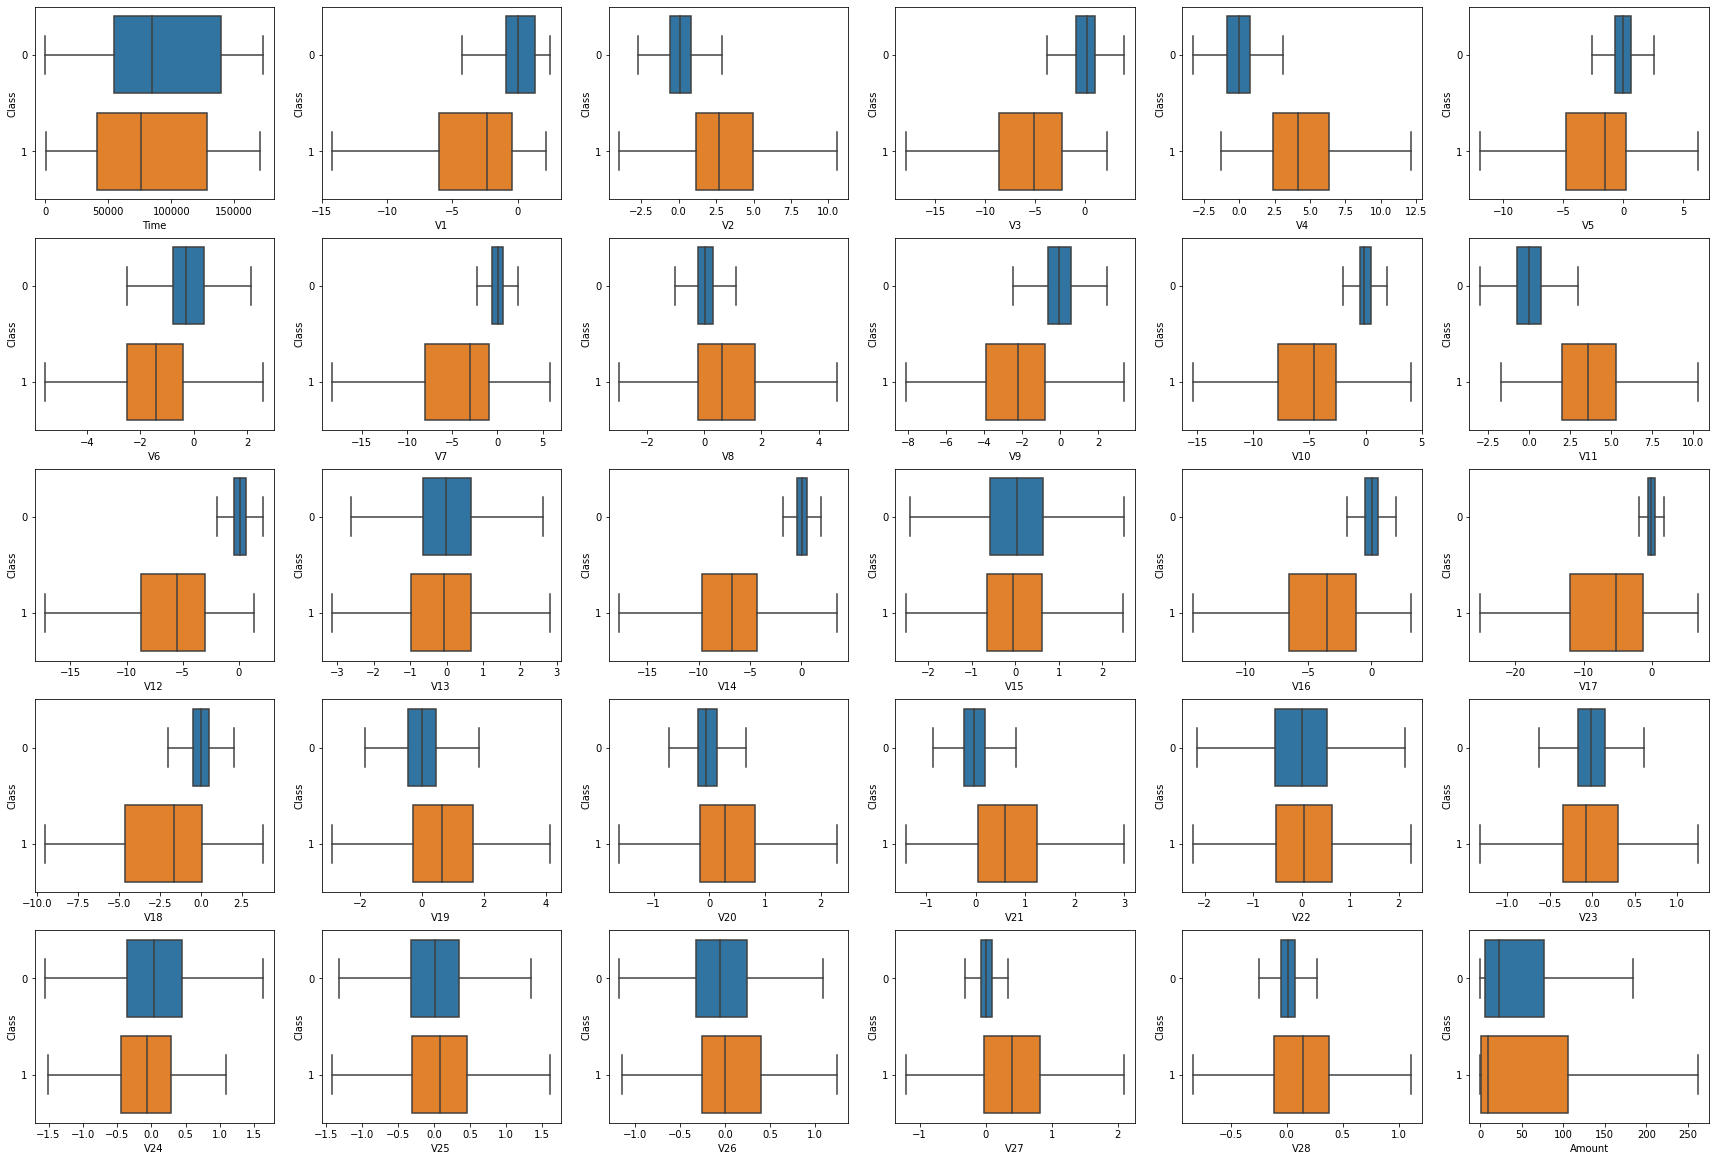

In [ ]:
# boxplots of all features without outliers
fig, axes = plt.subplots(5, 6)
for index, col in enumerate(X):
    ax = sns.boxplot(data=data, x=col, y="Class", orient="h", ax=axes[index // 6, index % 6], showfliers=False)
plt.subplots_adjust(top=4.0, right=4.0)

Now the difference of five-number summaries between the fraud and non-fraud data is more clear. While some features like $V25$ and $V26$ have similar stats, features like $V10$, $V12$, and $V14$ have much more difference between the classes. Furthermore, we can see that almost all the medians for the fraud class are zero while several of the non-fraud class medians are non-zero. Both these observations may hint to the possibility of some features being useful for the classification rather than others.

##### Check Linear Separability

We can create a Perceptron to determine if the data is linearly separable. We can fit the data into the Perceptron and if the accuracy is 1.0 then the data is linearly separable. Otherwise, it is not.

In [ ]:
# check linear separability using Perceptron algorithm
perceptron_model = Perceptron(tol=1e-3, max_iter=7e3)
perceptron_model.fit(X, y)
print("Mean Accuracy: %.4f" % perceptron_model.score(X, y))

Mean Accuracy: 0.9982


We can confirm that the data is not linearly separable. To obtain better results, we will use non-linear classifiers after we preprocess the data. 

#### Preprocessing

For the sake of complexity, we will scale all our features using the MinMaxScaler provided by sklearn.

In [ ]:
# scale all features between 0 and 1
min_max_scaler = MinMaxScaler()
X_minmaxscaled = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns)
X_minmaxscaled.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,...,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000
mean,0.548728,0.958294,0.767258,0.837414,0.251930,0.765716,0.263020,0.265355,0.785385,0.462780,...,0.580265,0.561479,0.510031,0.665434,0.382234,0.577907,0.425449,0.416511,0.313124,0.003439
std,0.274834,0.033276,0.017424,0.026275,0.062764,0.009292,0.013395,0.007537,0.012812,0.037846,...,0.008208,0.011841,0.033854,0.009274,0.081611,0.029261,0.078771,0.007450,0.006698,0.009736
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.313686,0.942658,0.760943,0.821985,0.214311,0.761060,0.255295,0.261980,0.783148,0.440626,...,0.578011,0.557798,0.484730,0.663030,0.334453,0.560105,0.372037,0.415203,0.312049,0.000218
50%,0.490147,0.958601,0.767949,0.840530,0.251051,0.765351,0.260263,0.265600,0.785625,0.461008,...,0.579600,0.561005,0.510347,0.665267,0.387756,0.578838,0.416932,0.416536,0.313352,0.000856
75%,0.806306,0.980645,0.775739,0.855214,0.284882,0.769836,0.267027,0.268831,0.788897,0.483350,...,0.581682,0.564484,0.534688,0.667626,0.441460,0.597593,0.464808,0.418191,0.314712,0.003003
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Feature Selection

Before doing any modeling, we can use Lasso Regression to determine which features (if any) are unimportant to the prediction of fraudulent and non-fraudulent transactions. Such features serve as noise and should be removed to prevent creating models that underperform. 

Before tuning the $\alpha$ hyperparameter in the Lasso class, we need to standardized the data to reduce the computational complexity of this procedure while preserving the magnitude of each feature.  

In [ ]:
# tune the alpha hyperparameter of Lasso Regression
pipeline = Pipeline([ ("scaler",StandardScaler()), ("model",Lasso()) ])
search = GridSearchCV(pipeline, {"model__alpha": 10 ** np.linspace(-6,6,13)}, scoring="neg_mean_squared_error", verbose=4)
search.fit(X, y)
search.best_params_

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 1/5] END ...............model__alpha=1e-06;, score=-0.002 total time=   1.7s
[CV 2/5] END ...............model__alpha=1e-06;, score=-0.001 total time=   1.9s
[CV 3/5] END ...............model__alpha=1e-06;, score=-0.001 total time=   1.8s
[CV 4/5] END ...............model__alpha=1e-06;, score=-0.001 total time=   2.2s
[CV 5/5] END ...............model__alpha=1e-06;, score=-0.001 total time=   1.9s
[CV 1/5] END ...............model__alpha=1e-05;, score=-0.002 total time=   1.2s
[CV 2/5] END ...............model__alpha=1e-05;, score=-0.001 total time=   1.4s
[CV 3/5] END ...............model__alpha=1e-05;, score=-0.001 total time=   1.3s
[CV 4/5] END ...............model__alpha=1e-05;, score=-0.001 total time=   1.2s
[CV 5/5] END ...............model__alpha=1e-05;, score=-0.001 total time=   1.2s
[CV 1/5] END ..............model__alpha=0.0001;, score=-0.002 total time=   0.7s
[CV 2/5] END ..............model__alpha=0.0001;,

{'model__alpha': 0.001}

In [ ]:
# we will now check the coefficients of each feature
# features with a non-zero coefficient are considered important
lasso_model_features = search.best_estimator_.feature_names_in_
lasso_model_coefs = search.best_estimator_.named_steps["model"].coef_
lasso_coefs = pd.DataFrame({"features": lasso_model_features, "coefs": abs(lasso_model_coefs)}, columns=["features", "coefs"])
lasso_coefs.sort_values(by=["coefs"], ascending=False)

,features,coefs
17,V17,0.012558
14,V14,0.011564
12,V12,0.009822
10,V10,0.008007
16,V16,0.007162
3,V3,0.007013
7,V7,0.006776
11,V11,0.005432
4,V4,0.004542
18,V18,0.003630


We can above that the coefficients of a few features converged to 0. Before removing the features, we will compare the boxplots once more to see if there are any visual patterns between which features are important and which are not.

In [ ]:
important_features = lasso_coefs.features[lasso_coefs.coefs != 0]
non_important_features = lasso_coefs.features[lasso_coefs.coefs == 0]

Important Features


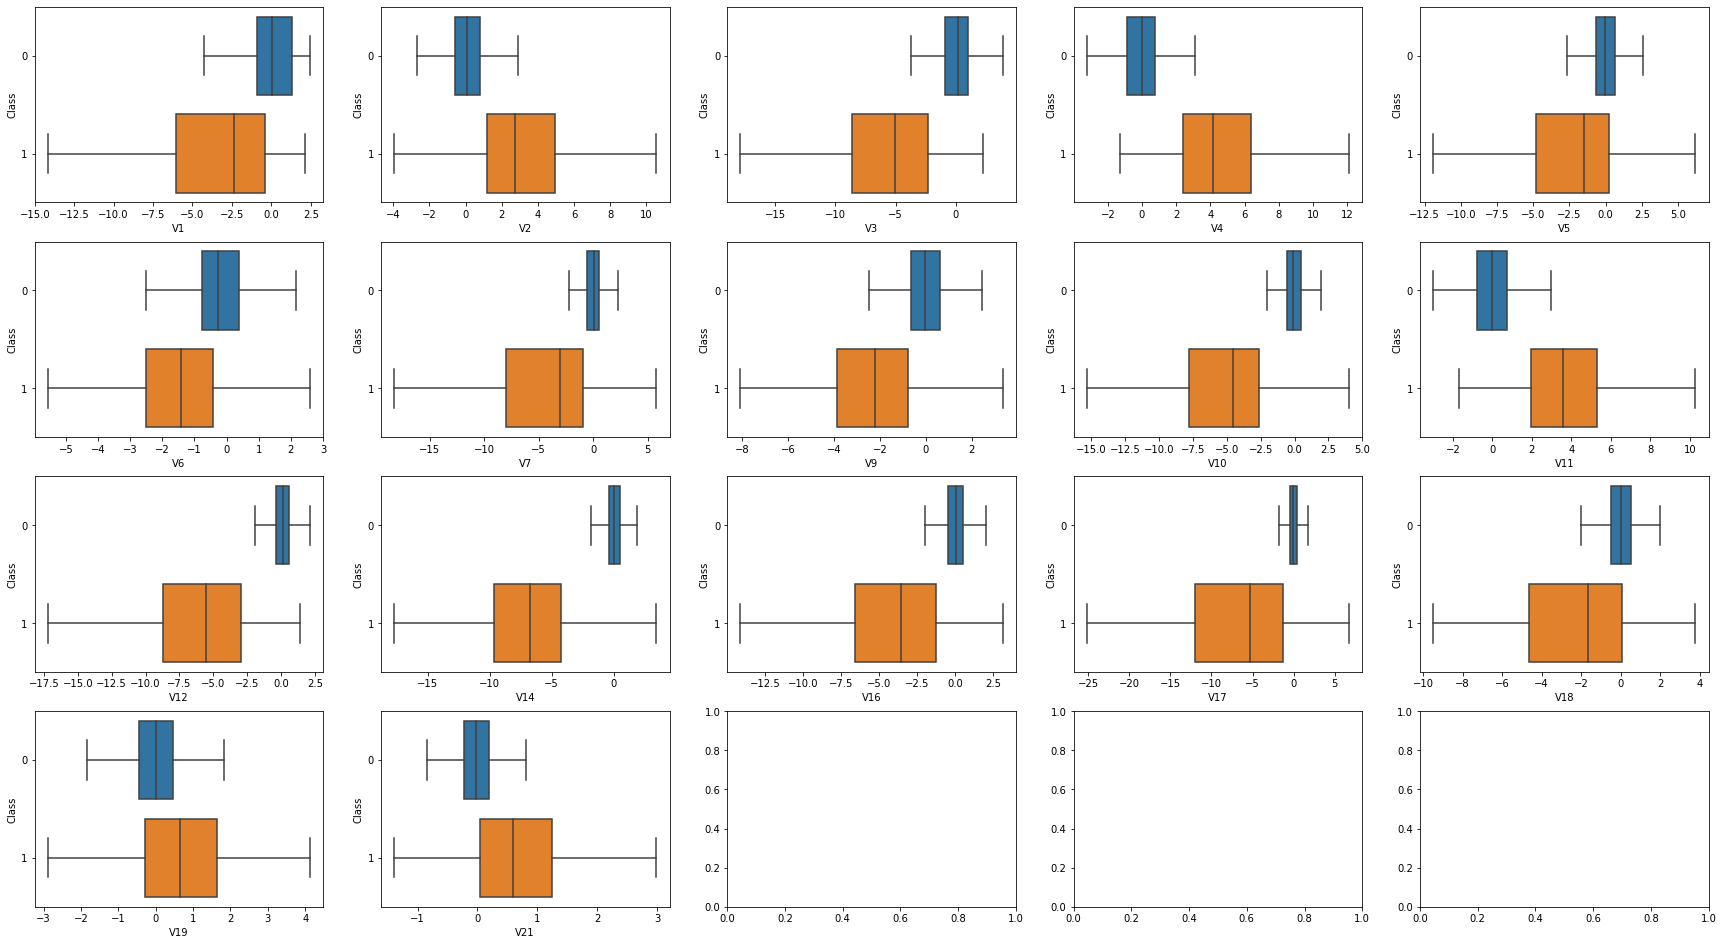

In [ ]:
print("Important Features")
fig, axes = plt.subplots(4, 5)
for index, col in enumerate(important_features):
    ax = sns.boxplot(data=data, x=col, y="Class", orient="h", ax=axes[index // 5, index % 5], showfliers=False)
plt.subplots_adjust(top=3.25, right=4.0)

Unimportant Features


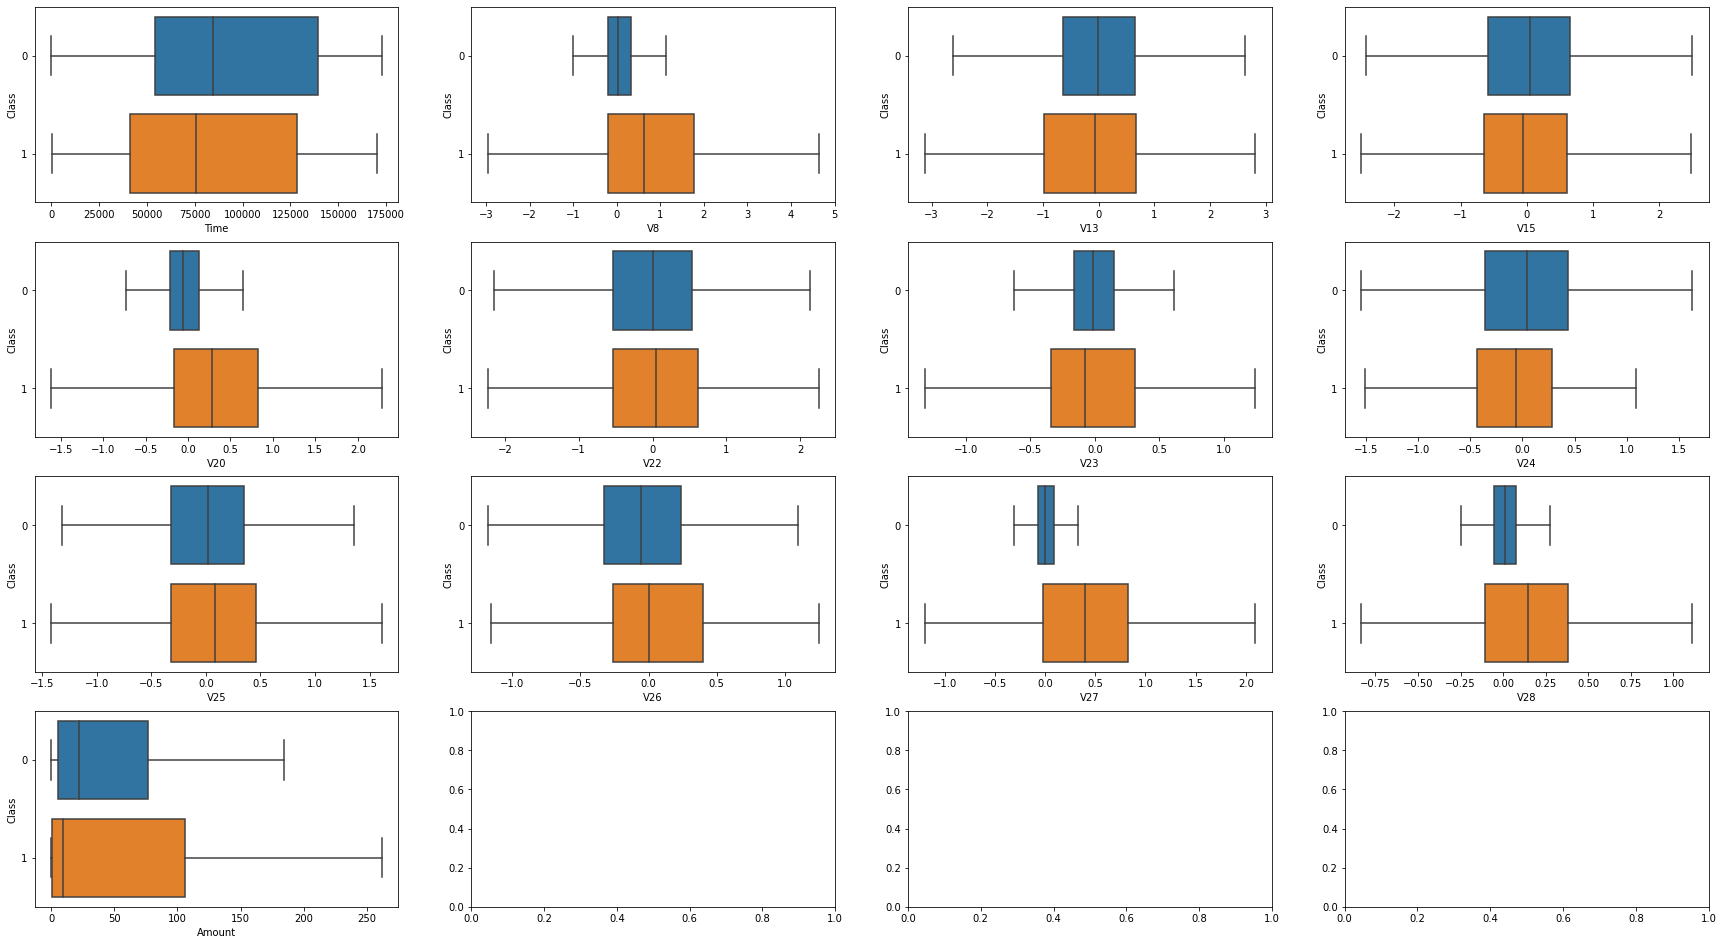

In [ ]:
print("Unimportant Features")
fig, axes = plt.subplots(4, 4)
for index, col in enumerate(non_important_features):
    ax = sns.boxplot(data=data, x=col, y="Class", orient="h", ax=axes[index // 4, index % 4], showfliers=False)
plt.subplots_adjust(top=3.25, right=4.0)

Interesting to see that all the non-important features are the features that have overlapping classes. We will remove the unimportant features and proceed with the Logistic Regression and SVM modeling.

In [ ]:
X_selected = X_minmaxscaled[important_features]
X_selected.describe()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21
count,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000,284806.000000
mean,0.958294,0.767258,0.837414,0.251930,0.765716,0.263020,0.265355,0.462780,0.508722,0.285286,0.704193,0.646053,0.449352,0.731130,0.653292,0.563315,0.561479
std,0.033276,0.017424,0.026275,0.062764,0.009292,0.013395,0.007537,0.037846,0.022528,0.060698,0.037660,0.032231,0.027866,0.024678,0.057647,0.063570,0.011841
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.942658,0.760943,0.821985,0.214311,0.761060,0.255295,0.261980,0.440626,0.497644,0.239944,0.688906,0.631744,0.434467,0.717074,0.618983,0.527681,0.557798
50%,0.958601,0.767949,0.840530,0.251051,0.765351,0.260263,0.265600,0.461008,0.506800,0.283338,0.709471,0.647755,0.451464,0.729222,0.653042,0.563607,0.561005
75%,0.980645,0.775739,0.855214,0.284882,0.769836,0.267027,0.268831,0.483350,0.518114,0.329266,0.727494,0.662635,0.465994,0.742743,0.687736,0.599155,0.564484
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Modeling

The two supervised learning models we are going to use for this project are Logistic Regression and Support Vector Machine (SVM). 

Logistic Regression is classification model that assumes the target values Binomially distributed. The model output the probability $P$ that an observations belongs to a certain class, $C_1$ for example. If $P \ge 0.5$ (where 0.5 is the decision threshold) for an observation, then that observation will belong to class $C_1$. Since our target value has a binary outcome, then the observation will belong to the other class, $C_2$ for example, if $P \le 0.5$. 

A Support Vector Machine is a classification and regression model that maps data into a high-dimensional space so that linearly inseparable data can be separated by a hyperplane, with the largest margin achievable between both classes, without overfitting. SVMs have two hyperparameters: $C$ and $\gamma$. 
- $C$: the C hyperparameter is a penalty parameter used to control error. Higher C values will make the SVM misclassify less points.
- $\gamma$: the gamma hyperparameter is used to give curvature weight on the decision boundary. Higher gamma values will fit the training data more precisely. 

In [ ]:
# split the data into a train test set while balancing the class ratio since the data is unbalanced
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y)

##### Logistic Regression

Next, we will create an Logistic Regression model on the entire dataset as the first run-through

In [ ]:
log_reg1 = LogisticRegression(max_iter=7e3)
log_reg1.fit(X_train, y_train)
y_test_logreg1 = log_reg1.predict(X_test)
accuracy = np.mean(y_test == y_test_logreg1)
print("Accuracy: %.4f" % accuracy)

Accuracy: 0.9990


The accuracy looks fantastic! However, since the data is unbalanced then the accuracy alone may not be the best metric to use because the over-represented class (non-fraudulent transactions) may be getting predicted more than the under-represented class (fraudulent transactions). We should use a confusion matrix to have a better look at these results. In the confusion matrix we are interested in three metrics: precision, recall, and F-1 score.

$$Precision = \frac{TP}{TP + FP}$$
(proportion of correctly predicted fraudulent transactions from the pool of transactions predicted fraudulent)

$$Recall = \frac{TP}{TP + FN}$$
(proportion of correctly predicted fraudulent transactions from the pool of transactions actually fraudulent)

$$F1 Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$
(measure of a model's accuracy on a dataset, especially an imbalanced one)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


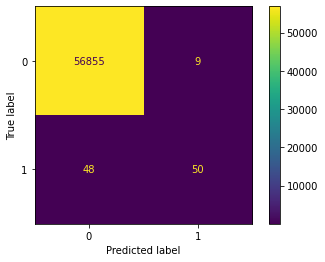

Precision: 0.8475
Recall 0.5102
F-Score: 0.6369


In [ ]:
plot_confusion_matrix(log_reg1, X_test, y_test)
plt.show()
precision = precision_score(y_test, y_test_logreg1)
recall = recall_score(y_test, y_test_logreg1)
fscore = f1_score(y_test, y_test_logreg1)
print("Precision: %.4f\nRecall %.4f\nF-Score: %.4f" % (precision, recall, fscore))

The confusion matrix and our metics above tells a more compelling story since we are particularly interested in detecting fraudulent transactions. Our goal will be to maximize these metrics by reducing the false positives and false negatives. We will need to do some more preprocessing to improve our model and our focus would be to improve the prediction of fraudulent transactions. 

##### Balancing Dataset
We can attempt to use the proposed approach discussed in the article [A Novel Approach for Handling Outliers in Imbalanced Data](https://www.sciencepubco.com/index.php/ijet/article/view/16783/7212). [2] The article suggest first splitting the data based on the targets so that we have majority data a minority data, then we generate synthetic data on the minority class using SMOTE (Synthetic Minority Oversampling Technique), and then we combine the majority and minority data back together and perform outlier removal using Mahalanobis distance. 

Let's begin this approach by oversampling the minority class using SMOTE.

In [ ]:
# oversample the minority class using SMOTE
smote = SMOTE(sampling_strategy=0.2)
oversampled_X, oversampled_y = smote.fit_resample(X_train, y_train)
oversampled_y.value_counts()

0    227450
1     45490
Name: Class, dtype: int64

In [ ]:
# fit a logistic regression model with the newly oversampled training data
log_reg2 = LogisticRegression(max_iter=7000)
log_reg2.fit(oversampled_X, oversampled_y)
y_test_logreg2 = log_reg2.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


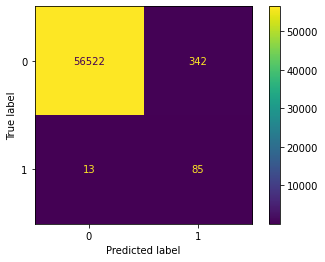

Precision: 0.1991
Recall 0.8673
F-Score: 0.3238


In [ ]:
plot_confusion_matrix(log_reg2, X_test, y_test)
plt.show()
precision = precision_score(y_test, y_test_logreg2)
recall = recall_score(y_test, y_test_logreg2)
fscore = f1_score(y_test, y_test_logreg2)
print("Precision: %.4f\nRecall %.4f\nF-Score: %.4f" % (precision, recall, fscore))

This is actually a lot worse now. The fact that there are more false negatives could mean that the increase in synthetic fraudulent transactions could have resulted in a ton of noise in the modeling. Even if we attempt to do outlier removal, we may still end up with more noise in the data than before. We should probably consider a less sophisticated approach. 

##### Tuning the Logistic Regression Decision Threshold

When doing Logistic Regression, we know that the probability of $C_1$ given the feature vector $\overrightarrow{x}$ is
$$P(C_1|\overrightarrow{x}) = \frac{1}{1 + e^{-(w^T\overrightarrow{x})}}$$

and we will classify an observation as $C_1$ if $P(C_1|\overrightarrow{x}) \ge 0.5$, where $0.5$ is the decision threshold. 

To facilitate our situation with the unbalanced data, we can tune the decision threshold until the F-1 score is maximized. 

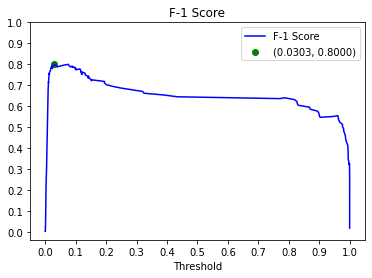

In [ ]:
# find the logistic regression decision threshold that minimizes the difference between the precision and recall
y_test_probability = log_reg1.predict_proba(X_test)
precision_arr, recall_arr, threshold_arr = precision_recall_curve(y_test, y_test_probability[:, 1])
fscore_arr = 2 * precision_arr * recall_arr / (precision_arr + recall_arr)
optimal_t_index = np.argmax(fscore_arr)
optimal_t = threshold_arr[optimal_t_index]

# plot results
plt.title("F-1 Score")
plt.scatter(optimal_t, fscore_arr[optimal_t_index], facecolor="green", label="(%.4f, %.4f)" % (optimal_t, fscore_arr[optimal_t_index]))
plt.plot(threshold_arr, fscore_arr[: -1], "blue", label="F-1 Score")
plt.xlabel("Threshold")
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.legend()
plt.show()

The graph above looks very promising! The fact that the decision threshold that yields the maximum F-1 score is very small should make sense. Since the data is extremely unbalanced, the decision boundary will be very small. 

Now let's perform stratified k-fold cross validation with this new approach. The benefit of using stratified k-fold cross validation over regular k-fold is that the former preserves the proportion of classes amongst all k folds. Using regular k-fold may results in some folds containing observations from only one class. 

In [ ]:
def modifiedLogisticRegression(X_data, y_data, kfold=None, max_iterations=7e3, decision_th=None):
    # X_data: dataframe containing inputs
    # y_data: series containing targets
    # kfold: KFold or StratifiedKFold object used for cross validation.
    # max_iterations: maximum number of iterations for the model
    # decision_th: custom decision threshold for Logistic Regression
    f1_scores = []

    # if kfold, store all k folds into a list. Otherwise, (X_data, y_data) is the only fold
    if kfold:
        folds = []
        for train_index, test_index in kfold.split(X_data, y_data):
            X_train, y_train = X_data.iloc[train_index], y_data.iloc[train_index]
            X_test, y_test = X_data.iloc[test_index], y_data.iloc[test_index]
            folds.append((X_train, X_test, y_train, y_test))
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data)
        folds = [(X_train, X_test, y_train, y_test)]

    # perform modified logistic regression
    for X_train, X_test, y_train, y_test in folds:
        # use the logistic regression model with modified decision threshold
        log_reg_model = LogisticRegression(max_iter=max_iterations)
        log_reg_model.fit(X_train, y_train)

        # compute the optimal decision threshold (or use decision_th) and predict y_test
        y_test_prob = log_reg_model.predict_proba(X_test)
        if decision_th:
            y_test_hat = (log_reg_model.predict_proba(X_test)[:, 1] >= decision_th).astype(int)
        else:
            precision_arr, recall_arr, threshold_arr = precision_recall_curve(y_test, y_test_prob[:, 1])
            f_arr = 2 * precision_arr * recall_arr / (precision_arr + recall_arr)
            optimal_t = threshold_arr[np.argmax(f_arr)]
            y_test_hat = (log_reg_model.predict_proba(X_test)[:, 1] >= optimal_t).astype(int)
        
        # compute precision, recall, and f-score
        precision = precision_score(y_test, y_test_hat)
        recall = recall_score(y_test, y_test_hat)
        fscore = f1_score(y_test, y_test_hat)
        f1_scores.append(fscore)
        print("Threshold: %.4f, Precision: %.4f, Recall %.4f, F-1 Score: %.4f" % (optimal_t, precision, recall, fscore))
    
    return f1_scores


In [ ]:
skf = StratifiedKFold(n_splits=5)

In [ ]:
logreg_scores = modifiedLogisticRegression(X_data=X_selected, y_data=y, kfold=skf)
print("Average F-1 score: %.4f" % np.mean(logreg_scores))

Threshold: 0.1186, Precision: 0.7031, Recall 0.9091, F1-Score: 0.7930
Threshold: 0.0278, Precision: 0.9535, Recall 0.8367, F1-Score: 0.8913
Threshold: 0.0347, Precision: 0.7273, Recall 0.6531, F1-Score: 0.6882
Threshold: 0.1397, Precision: 0.9600, Recall 0.7347, F1-Score: 0.8324
Threshold: 0.0149, Precision: 0.7723, Recall 0.7879, F1-Score: 0.7800
Average F-1 score: 0.7970


We can see from the results above that the second fold is the one with the highest F-1 Score and has a decision threshold of $0.0278$. While the F-1 Score is $0.8913$ and average F-1 Score is $0.7970$, we may consider using other models for a better prediction.  

##### Support Vector Machine

Let's begin by using an SVM with its default values ($C$=1.0, $\gamma$=$(n_{features} \times X.var())^{-1}$)

In [ ]:
svm_classif = SVC()
svm_classif.fit(X_train, y_train)
y_test_svm1 = svm_classif.predict(X_test)

precision = precision_score(y_test, y_test_svm1)
recall = recall_score(y_test, y_test_svm1)
fscore = f1_score(y_test, y_test_svm1)
print("Precision: %.4f\nRecall %.4f\nF-Score: %.4f" % (precision, recall, fscore))

Precision: 0.8587
Recall 0.8061
F-Score: 0.8316


Not too bad for the first run! It is worth noting that SVMs do not perform well under the presence of outliers because outliers can lead to a high misclassification rate which may also increase the computational power required to make the model converge. Let's consider removing the observations that contain outliers and are also classified as non-fraudulent. 

##### Outlier Removal

In [ ]:
# extract all rows that are either fraudulent or do not have outliers in any features and are non-fraudulent
# drop all unimportant features
indices = np.logical_or(np.logical_and((np.abs(stats.zscore(X)) < 3).all(axis=1), y == 0), y == 1)
X_nofliers = X[indices]
y_nofliers = y[indices]
X_nofliers = X_nofliers.drop(non_important_features, axis=1)

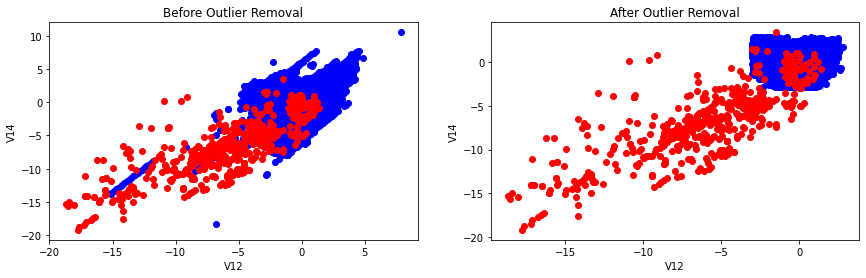

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Before Outlier Removal")
plt.scatter(X.V12[y == 0], X.V14[y == 0], c="b")
plt.scatter(X.V12[y == 1], X.V14[y == 1], c="r")
plt.xlabel("V12")
plt.ylabel("V14")

plt.subplot(1, 2, 2)
plt.title("After Outlier Removal")
plt.scatter(X_nofliers.V12[y_nofliers == 0], X_nofliers.V14[y_nofliers == 0], c="b")
plt.scatter(X_nofliers.V12[y_nofliers == 1], X_nofliers.V14[y_nofliers == 1], c="r")
plt.xlabel("V12")
plt.ylabel("V14")

plt.subplots_adjust(right=2.0)
plt.show()

In [ ]:
y_nofliers.value_counts()

0    246942
1       492
Name: Class, dtype: int64

We can see above that the outlier removal dramatically improved the decision boundary between the classes. The features $V12$ and $V14$ were chosen arbitrarily for this example. 

##### Retry SVM Without Outliers

Let's check the performance of an SVM without outliers in the data. We should see an improvement!

In [ ]:
# standardize all features for the SVM models
stan_scaler = StandardScaler()
X_nofliers = pd.DataFrame(stan_scaler.fit_transform(X_nofliers), columns=X_nofliers.columns)

In [ ]:
# split the data into a train test set
X_train_nofliers, X_test_nofliers, y_train_nofliers, y_test_nofliers = train_test_split(X_nofliers, y_nofliers, test_size=0.2, stratify=y_nofliers)

In [ ]:
svm_classif = SVC(max_iter=7e3)
svm_classif.fit(X_train_nofliers, y_train_nofliers)
y_test_svm2 = svm_classif.predict(X_test_nofliers)

precision = precision_score(y_test_nofliers, y_test_svm2)
recall = recall_score(y_test_nofliers, y_test_svm2)
fscore = f1_score(y_test_nofliers, y_test_svm2)
print("Precision: %.4f\nRecall %.4f\nF-Score: %.4f" % (precision, recall, fscore))

Precision: 1.0000
Recall 0.8571
F-Score: 0.9231


The performance of this SVM classifier overcomes the performance of our modified Logistic Regression approach! 

Perhaps we can improve these results further by tuning the $C$ parameter of the SVM. We can do this using GridSearchCV. 

In [ ]:
skf_split = skf.split(X_nofliers, y_nofliers)

In [ ]:
grid = {"C": 10 ** np.linspace(-1, 4, 6)}
svm_cv = GridSearchCV(svm_classif, grid, scoring="f1", cv=skf_split, verbose=4)
svm_cv.fit(X_nofliers, y_nofliers)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .............................C=0.1;, score=0.097 total time=  24.7s
[CV 2/5] END .............................C=0.1;, score=0.339 total time=  25.3s
[CV 3/5] END .............................C=0.1;, score=0.322 total time=  25.0s
[CV 4/5] END .............................C=0.1;, score=0.096 total time=  25.6s
[CV 5/5] END .............................C=0.1;, score=0.168 total time=  24.7s
[CV 1/5] END .............................C=1.0;, score=0.952 total time=  41.2s
[CV 2/5] END .............................C=1.0;, score=0.923 total time=  39.0s
[CV 3/5] END .............................C=1.0;, score=0.894 total time=  38.2s
[CV 4/5] END .............................C=1.0;, score=0.935 total time=  48.2s
[CV 5/5] END .............................C=1.0;, score=0.905 total time=  40.4s
[CV 1/5] END ............................C=10.0;, score=0.947 total time=  41.5s
[CV 2/5] END ............................C=10.0;,

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END ...........................C=100.0;, score=0.587 total time=  14.6s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END ...........................C=100.0;, score=0.783 total time=  22.2s
[CV 3/5] END ...........................C=100.0;, score=0.535 total time=  28.4s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END ...........................C=100.0;, score=0.610 total time=  22.2s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END ...........................C=100.0;, score=0.837 total time=  22.4s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END ..........................C=1000.0;, score=0.421 total time=  12.2s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END ..........................C=1000.0;, score=0.514 total time=  11.1s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END ..........................C=1000.0;, score=0.521 total time=  10.5s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END ..........................C=1000.0;, score=0.382 total time=  11.6s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END ..........................C=1000.0;, score=0.583 total time=  11.6s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END .........................C=10000.0;, score=0.280 total time=  11.0s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END .........................C=10000.0;, score=0.394 total time=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END .........................C=10000.0;, score=0.414 total time=   9.1s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END .........................C=10000.0;, score=0.252 total time=  11.0s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END .........................C=10000.0;, score=0.353 total time=  10.3s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f8fac50e950>,
             estimator=SVC(max_iter=7000.0),
             param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])},
             scoring='f1', verbose=4)

In [ ]:
svm_best = svm_cv.best_params_
svm_best

{'C': 1.0}

The optimal $C$ hyperparameter value is $1.0$ which is the same $C$ value used initially. 

##### Stratified K-Fold Cross Validation on Logistic Regression and SVM Without Outliers 

To ensure these results are accurate, we will perform Stratified K-Fold Cross Validation on both the modified Logistic Regression and SVM models without outliers in the data. 

Let's start with modified Logistic Regression. 

In [ ]:
logreg_scores2 = modifiedLogisticRegression(X_data=X_nofliers, y_data=y_nofliers, kfold=skf)
print("Average F-1 score: %.4f" % np.mean(logreg_scores2))

Threshold: 0.9992, Precision: 1.0000, Recall 0.9082, F1-Score: 0.9519
Threshold: 0.1595, Precision: 0.9884, Recall 0.8673, F1-Score: 0.9239
Threshold: 0.9829, Precision: 1.0000, Recall 0.7273, F1-Score: 0.8421
Threshold: 0.3392, Precision: 0.9780, Recall 0.8990, F1-Score: 0.9368
Threshold: 0.1862, Precision: 1.0000, Recall 0.8265, F1-Score: 0.9050
Average F-1 score: 0.9120


This time, the best results come from the first fold, which has a precision of $1.0$ and an average F-1 Score of $0.9120$. This means that the removal of outliers and standardization of the data made the average F-1 score rise about $0.11$. 

We will now perform Stratified K-Fold Cross validation on our SVM model. 

In [ ]:
svm_classif2 = SVC(max_iter=7e3)
svm_scores = cross_val_score(svm_classif2, X_nofliers, y_nofliers, scoring="f1", cv=skf)

In [ ]:
[print("Fold %d F-1 Score: %.4f" % (i+1, svm_scores[i])) for i in range(len(svm_scores))]
print("Average F-1 score: %.4f" % np.mean(svm_scores))

Fold 1 F-1 Score: 0.9519
Fold 2 F-1 Score: 0.9231
Fold 3 F-1 Score: 0.8939
Fold 4 F-1 Score: 0.9355
Fold 5 F-1 Score: 0.9050
Average F-1 score: 0.9219


Both the modified Logistic Regression and SVM models are performing well.

### Results

Below is a summary of all Logistic Regression (LR) and Support Vector Machine (SVM) classifiers. 

<br>

| Metric      | LR (initial)| LR (with SMOTE) | SVM (initial) | SVM (w/o outliers) |
| ----------- | ----------- | --------------- | ------------- | ------ |
| Precision   | 0.8475      | 0.1991          | 0.8587        | ***1.0000*** |
| Recall      | 0.5102      | ***0.8673***     | 0.8061        | 0.8571 |
| F-1 Score   | 0.6369      | 0.3238          | 0.8316        | ***0.9231*** |

<br>

| Modified LR Cross Validation |1 |2 |3 |4 |5 | Average |
|--|--|--|--|--|--| ------- |
| Threshold | 0.1186 | 0.0278 | 0.0347 | 0.1397 | 0.0149 | 0.0671 |
| Precision | 0.7031 | 0.9535 | 0.7273 | ***0.9600*** | 0.7723 | 0.8232 |
| Recall    | ***0.9091*** | 0.8367 | 0.6531 | 0.7347 | 0.7879 | 0.7843 |
| F-1 Score | 0.7930 | ***0.8913*** | 0.6882 | 0.8324 | 0.7800 | 0.7970 |

<br>

| Modified LR (without outliers) Cross Validation |1 |2 |3 |4 |5 | Average |
|--|--|--|--|--|--| ------- |
| Threshold | 0.9992 | 0.1595 | 0.9829 | 0.3392 | 0.1862 | 0.5334 |
| Precision | ***1.0000*** | 0.9884 | ***1.0000*** | 0.9780 | ***1.0000*** | 0.9933 |
| Recall    | ***0.9082*** | 0.8673 | 0.7273 | 0.8990 | 0.8265 | 0.8457 |
| F-1 Score | ***0.9519*** | 0.9239 | 0.8421 | 0.9368 | 0.9050 | 0.9120 |
 
<br>

| SVM (without outliers) Cross Validation |1 |2 |3 |4 |5 | Average |
|--|--|--|--|--|--| ------- |
| F-1 Score | ***0.9519*** | 0.9231 | 0.8939 | 0.9355 | 0.9050 | 0.9219 |


### Discussions

Creating accurate and reliable machine learning models for detecting credit card fraud is challenging. Although the Credit Card Fraud Detection dataset did not contain missing values, nor did it have categorical features that required encoding algorithms such as one-hot encoding, the dataset was extremely imbalanced because of the rarity of fraudulent credit card transactions. Our main priority was to detect credit card fraud when it occurs, but there were only 492 observations available to learn from within a dataset containing 284,806 observations. 
    
One may argue that it would be more beneficial to acquire some context or description of the features that were kept confidential for the security of the cardholders. Knowing this context may allow the data scientist to make more intuitive decisions based on the analysis. However, the focus of this project was related to the methods used to produce accurate predictive models rather than making business decisions. 

### Conclusions

This project uses supervised learning models such as Logistic Regression and Support Vector Machines and other techniques to make accurate and reliable models for detecting credit card fraud. The performances of the models that we created in this report were relatively good since we achieved accuracies above 90%, especially when using an extremely unbalanced dataset to learn from. However, such results would not be ideal in the context of the problem because there will be significant consequences if a bank fails to predict when a transaction is fraudulent. Such an event would diminish the trust that the cardholders have in the bank. Using other models such as neural networks and other techniques such as ensembles could potentially overcome the results we have obtained in this project, which is worth keeping in mind in the future. 

### References
- [1] https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- [2] https://www.sciencepubco.com/index.php/ijet/article/view/16783/7212
- [3] https://slideplayer.com/slide/9291706/
- [4] http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.121.6481&rep=rep1&type=pdf
- [5] https://www.ibm.com/docs/en/spss-modeler/SaaS?topic=models-how-svm-works